![](/images/blog/heatmap-simulation.png)

[My research](/research) focuses on analyzing maps of the 3D structure of the genome. One of the things I always find helpful when trying to understand complex data like this is trying to simulate it myself to get a sense for how the data might behave. In this post, we'll add complexity step-by-step and work our way up to simulating realistic-looking genome folding maps from scratch!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/19XfIwzGN0Zk0F48QBjjXIzt9yEq9DwFp)

<!-- TEASER_END -->

This notebook will use a few plotters and utilities from the [lib5c library](https://lib5c.readthedocs.io/) - we'll go ahead and install it first:

In [0]:
!pip install lib5c

In [0]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from lib5c.util.mathematics import symmetrize
from lib5c.util.bed import parse_feature_from_string
from lib5c.algorithms.expected import make_expected_matrix_from_list
from lib5c.plotters.extendable import ExtendableHeatmap
from lib5c.plotters.heatmap import plot_heatmap

This notebook walks through the process of simulating a contact heatmap with a single "real" loop in it, together with multiple kinds of noise, bias, and technical artifacts observed in 5C and Hi-C data.

Set random seed for reproducibility:

In [0]:
np.random.seed(42)

Define a genomic range that the simulated heatmap is supposed to cover. Since we're not drawing rulers or gene tracks or aligning any external data to the heatmap, this is completely arbitrary.

In [0]:
GRANGE = parse_feature_from_string('chr3:34100000-35110000')

Define some functions for adding loops, distance dependence, and noise to a matrix.

These functions all take in the contact matrix `matrix` and modify it in-place, returning nothing.

First, we model distance dependence effects using a power-law relationship

$$f(d) = c \times d ^ {-\alpha}$$

where $f(d)$ represents the expected number of contacts for the interaction of points separated by $d$ bins (in other words, on the $d$th diagonal of the contact matrix), $c$ represents the contact frequency on the diagonal (since $f(0) = c$), and $\alpha$ represents the rate at which contacts become less frequent as you move away from the diagonal of the contact matrix.

This function also allows us to specify a `start` and `end` position for the distance dependence zone, which we will use to model contact domains/TADs. We will think of TADs as zones of the contact matrix that have additional distance dependence effects in addition to the global average distance dependence effect.

In [0]:
def add_dd_zone(matrix, start, end, c, alpha):
    dd = c * (np.arange(end-start) + 1) ** -alpha
    matrix[start:end, start:end] += make_expected_matrix_from_list(dd)

Next, we model loops. Loops appear in the contact matrix as punctate zones of increased contact frequency, but in practice we rarely see loops that increase the contact frequency of just one entry in the contact matrix. Instead, we model one biological loop as increasing the contact frequency of a few nearby entries of the contact matrix, with the largest increases occuring near the "epicenter" of the loop, and smaller increases surrounding it. To model this, we essentially take a two-dimensional isotropic normal distribution with covariance matrix $\Sigma = \left[ {\begin{array}{cc} 1/\tau & 0 \\ 0 & 1/\tau \\ \end{array} } \right]$ (where $\tau$ represents a precision and controlls how punctate the loop is, passed as the parameter `size`), compute its integral under squares of a grid (whose size is $2r+1 \times 2r+1$, as controlled by the parameter `r`), and normalize it so that the sum of all values in the grid equals one. We can then scale this grid by a loop strength parameter `strength` (which represents the total number of contacts which will be added to the contact matrix by the loop) and add it on top of a specified submatrix of the full contact matrix (centered at `x`, `y`).

In [0]:
def gkern(kernlen=21, nsig=3):
    """https://stackoverflow.com/a/29731818"""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(stats.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw / kernel_raw.sum()
    return kernel

In [0]:
def add_loop(matrix, x, y, r, size, strength):
    matrix[x-r:x+r+1, y-r:y+r+1] += strength * gkern(2*r+1, size)

Next, we model noise. In practice, the raw data in 5C and Hi-C experiments comes from counting reads from high-throughput sequencing, so the real process respsonsible for the noise is likely to be Poisson or negative binomial. For simplicity, we choose to use a simple independently distributed normal noise term whose standard deviation is controlled by the `strength` parameter.

In [0]:
def add_noise(matrix, strength):
    matrix += strength * symmetrize(np.random.normal(size=matrix.shape))

Finally, we model "bias," a term we use to refer to how intrinsic properties of specific restriction fragments (and therefore bins in the contact matrix) cause them to be detected more or less frequently. For example, if a particular bin contains many repetitive sequences which impede the ability of the sequence aligner to uniquely identify specific sequencing reads as coming from that particular bin, then that bin (an entire row and column of the contact matrix) may have reduced values compared to neighboring columns that are not so difficult to align reads to. We choose to lump all possible biases like this into one multiplicative factor for each bin (row/column of the contact matrix), and model the observed, "biased" contact frequency $Y_{i, j}$ for the interaction between the $i$th and $j$th bin as some true contact frequency $X_{i,j}$ times the product of the bias factors for the $i$th and $j$th bin ($b_i$ and $b_j$, respectively):

$$Y_{i, j} = X_{i, j} \times b_i \times b_j$$

Multiplicative bias factors are probably distributed around 1, so we choose to model them as indepentent draws from a log-normal distribution with standard deviation equal to the square root of the `strength` parameter.

In [0]:
def add_bias(matrix, strength):
    s = np.sqrt(strength)
    bias = np.exp(s * np.random.normal(size=matrix.shape[0]))[:, np.newaxis]
    matrix *= bias
    matrix *= bias.T

Start with a blank 100 x 100 matrix and add a loop

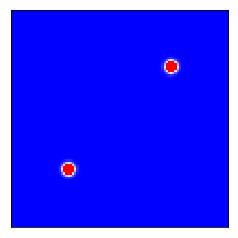

In [0]:
matrix = np.zeros((100, 100))
add_loop(matrix, 73, 26, 20, 20, 50)
add_loop(matrix, 26, 73, 20, 20, 50)
h = ExtendableHeatmap(
    array=matrix,
    grange_x=GRANGE,
    colormap='bwr',
    colorscale=(0, 1)
)

Add distance dependence. The first zone (from 0 to 100) covers the entire heatmap and represents the global distance dependence. The following three zones cover only parts of the heatmap and represent TADs/subTADs.

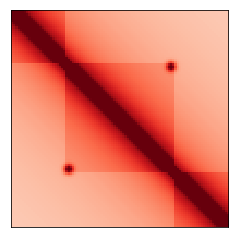

In [0]:
add_dd_zone(matrix, 0, 100, 10, 1/2.)
add_dd_zone(matrix, 0, 25, 1.5, 1/3.)
add_dd_zone(matrix, 25, 75, 1.5, 1/3.)
add_dd_zone(matrix, 75, 100, 1.5, 1/3.)
h = ExtendableHeatmap(
    array=matrix,
    grange_x=GRANGE,
    colormap='Reds',
    colorscale=(0, 5)
)

Outline the loops with green boxes.

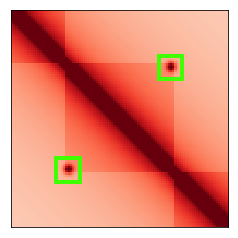

In [0]:
h.outline_cluster([{'x': x, 'y': y}
                   for x in range(21, 32) for y in range(68, 79)], '#40ff00', 4)
h.outline_cluster([{'x': x, 'y': y}
                   for x in range(68, 79) for y in range(21, 32)], '#40ff00', 4)
h.fig

Add noise to the heatmap.

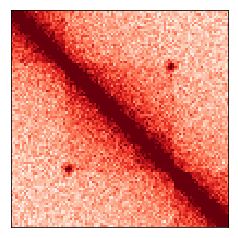

In [0]:
add_noise(matrix, 0.5)
h = ExtendableHeatmap(
    array=matrix,
    grange_x=GRANGE,
    colormap='Reds',
    colorscale=(0, 5)
)

Add bias to the heatmap.

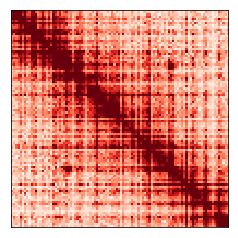

In [0]:
add_bias(matrix, 0.1)
h = ExtendableHeatmap(
    array=matrix,
    grange_x=GRANGE,
    colormap='Reds',
    colorscale=(0, 5)
)

The heatmap above represents our final simulated "raw" data. The loop is hard to see by eye at this stage, but a good loop-calling algorithm should identify it very easily.

Reproduce the "expected" matrix by adding just distance dependence, but no noise, loops, or bias to a blank 100 x 100 matrix.

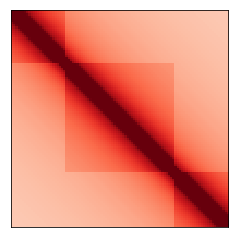

In [0]:
matrix = np.zeros((100, 100))
add_dd_zone(matrix, 0, 100, 10, 1/2.)
add_dd_zone(matrix, 0, 25, 1.5, 1/3.)
add_dd_zone(matrix, 25, 75, 1.5, 1/3.)
add_dd_zone(matrix, 75, 100, 1.5, 1/3.)
h = ExtendableHeatmap(
    array=matrix,
    grange_x=GRANGE,
    colormap='Reds',
    colorscale=(0, 5)
)